# BFS Performance Benchmarking
# Skip notebook test

This notebook benchmarks performance of running BFS within cuGraph against NetworkX. 


| Author Credit |    Date    |  Update          | cuGraph Version |  Test Hardware |
| --------------|------------|------------------|-----------------|----------------|
| Brad Rees     | 08/16/2020 | created          | 0.15            | GV100 32G, CUDA 10.2
| Don Acosta    | 05/15/2023 | update and test  | 23.06           | A6000 32G, CUDA 11.7

### Test Data

| File Name              | Num of Vertices | Num of Edges |
|:---------------------- | --------------: | -----------: |
| preferentialAttachment |         100,000 |      999,970 |
| caidaRouterLevel       |         192,244 |    1,218,132 |
| coAuthorsDBLP          |         299,067 |    1,955,352 |
| dblp-2010              |         326,186 |    1,615,400 |
| citationCiteseer       |         268,495 |    2,313,294 |
| coPapersDBLP           |         540,486 |   30,491,458 |
| coPapersCiteseer       |         434,102 |   32,073,440 |
| as-Skitter             |       1,696,415 |   22,190,596 |




### Timing 
What is not timed:  Reading the data</p>
What is timmed: (1) creating a Graph, (2) running BSF


## NOTICE:
You must have run the dataPrep script prior to running this notebook so that the data is downloaded

See the README file in this folder for a discription of how to get the data

## Now load the required libraries

In [1]:
# Import needed libraries
import gc
import time
import rmm
import cugraph
import cudf
import os

In [2]:
# NetworkX libraries
import networkx as nx
from scipy.io import mmread

In [3]:
try: 
    import matplotlib
except ModuleNotFoundError:
    os.system('pip install matplotlib')

In [4]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

### Define the test data

In [5]:
# Test File
data = {
    'preferentialAttachment' : './data/preferentialAttachment.mtx',
    'caidaRouterLevel'       : './data/caidaRouterLevel.mtx',
    'coAuthorsDBLP'          : './data/coAuthorsDBLP.mtx',
    'dblp'                   : './data/dblp-2010.mtx',
    'citationCiteseer'       : './data/citationCiteseer.mtx',
    'coPapersDBLP'           : './data/coPapersDBLP.mtx',
    'coPapersCiteseer'       : './data/coPapersCiteseer.mtx',
    'as-Skitter'             : './data/as-Skitter.mtx'
}

### Define the testing functions

In [6]:
# Data reader - the file format is MTX, so we will use the reader from SciPy
def read_mtx_file(mm_file):
    print('Reading ' + str(mm_file) + '...')
    M = mmread(mm_file).asfptype()
     
    return M

In [7]:
# CuGraph BFS

def cugraph_call(M):

    gdf = cudf.DataFrame()
    gdf['src'] = M.row
    gdf['dst'] = M.col
    
    print('\tcuGraph Solving... ')
    
    t1 = time.time()
        
    # cugraph Pagerank Call
    G = cugraph.Graph(directed=True)
    G.from_cudf_edgelist(gdf, source='src', destination='dst', renumber=False)
    
    df = cugraph.bfs(G, 1)
    t2 = time.time() - t1
    
    return t2
    

In [8]:
# Basic NetworkX BFS

def networkx_call(M):
    nnz_per_row = {r: 0 for r in range(M.get_shape()[0])}
    for nnz in range(M.getnnz()):
        nnz_per_row[M.row[nnz]] = 1 + nnz_per_row[M.row[nnz]]
    for nnz in range(M.getnnz()):
        M.data[nnz] = 1.0/float(nnz_per_row[M.row[nnz]])

    M = M.tocsr()
    if M is None:
        raise TypeError('Could not read the input graph')
    if M.shape[0] != M.shape[1]:
        raise TypeError('Shape is not square')

    # should be autosorted, but check just to make sure
    if not M.has_sorted_indices:
        print('sort_indices ... ')
        M.sort_indices()

    z = {k: 1.0/M.shape[0] for k in range(M.shape[0])}
        
    print('\tNetworkX Solving... ')
        
    # start timer
    t1 = time.time()
    
    Gnx = nx.DiGraph(M)

    pr = nx.bfs_edges(Gnx, 1)
    
    t2 = time.time() - t1

    return t2

### Run the benchmarks

In [9]:
# arrays to capture performance gains
perf_nx = []
names = []
time_cu = []
time_nx = []

# do a simple pass just to get all the libraries initiallized
v = './data/preferentialAttachment.mtx'
M = read_mtx_file(v)
trapids = cugraph_call(M)
del M

for k,v in data.items():
    gc.collect()

    # Saved the file Name
    names.append(k)
    
    # read the data
    M = read_mtx_file(v)
    
    
    # call cuGraph - this will be the baseline
    trapids = cugraph_call(M)
    
    # Now call NetworkX
    tn = networkx_call(M)
    speedUp = (tn / trapids)
    perf_nx.append(speedUp)
    time_cu.append(trapids)
    time_nx.append(tn)
    del M
    
    print("\tcuGraph (" + str(trapids) + ")  Nx (" + str(tn) + ")" )

Reading ./data/preferentialAttachment.mtx...
	cuGraph Solving... 
Reading ./data/preferentialAttachment.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
	cuGraph (0.020940780639648438)  Nx (4.338929653167725)
Reading ./data/caidaRouterLevel.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
	cuGraph (0.024698734283447266)  Nx (5.54830265045166)
Reading ./data/coAuthorsDBLP.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
	cuGraph (0.029554128646850586)  Nx (8.57802963256836)
Reading ./data/dblp-2010.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
	cuGraph (0.026847124099731445)  Nx (6.8994972705841064)
Reading ./data/citationCiteseer.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
	cuGraph (0.0343780517578125)  Nx (10.67018461227417)
Reading ./data/coPapersDBLP.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
	cuGraph (0.3869767189025879)  Nx (113.43171763420105)
Reading ./data/coPapersCiteseer.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
	cuGraph (0.5291621685028076)  Nx (1

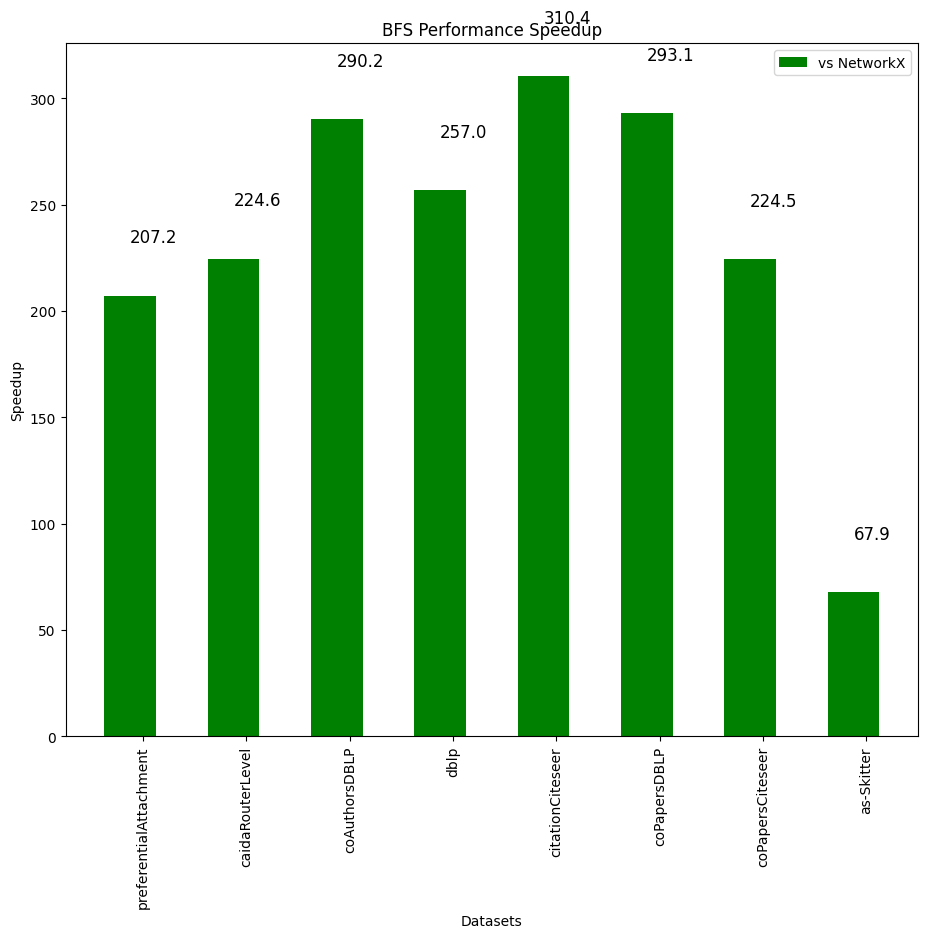

In [10]:
%matplotlib inline

plt.figure(figsize=(11,9))

bar_width = 0.5
index = np.arange(len(names))

_ = plt.bar(index, perf_nx, bar_width, color='g', label='vs NetworkX')



plt.xlabel('Datasets')
plt.ylabel('Speedup')
plt.title('BFS Performance Speedup')
plt.xticks(index + (bar_width/4), names)
plt.xticks(rotation=90) 

# Text on the top of each barplot
for i in range(len(perf_nx)):
    plt.text(x = (i - .5) + bar_width, y = perf_nx[i] + 25, s = round(perf_nx[i], 1), size = 12)

plt.legend()
plt.show()

# Dump the raw data

In [11]:
# print the speed-up numbers
perf_nx

[207.19999544585116,
 224.63914898546247,
 290.2480981614889,
 256.9920429821056,
 310.37781569019086,
 293.1228471725059,
 224.4911688256685,
 67.91805169483405]

In [12]:
# print the cuGraph runtimes
time_cu

[0.020940780639648438,
 0.024698734283447266,
 0.029554128646850586,
 0.026847124099731445,
 0.0343780517578125,
 0.3869767189025879,
 0.5291621685028076,
 1.3857977390289307]

In [13]:
# print the NetworkX runtimes
time_nx

[4.338929653167725,
 5.54830265045166,
 8.57802963256836,
 6.8994972705841064,
 10.67018461227417,
 113.43171763420105,
 118.79223370552063,
 94.12068247795105]

___
Copyright (c) 2020-2023, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License");  you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
___